<a href="https://colab.research.google.com/github/thedevwonder/rl-sutton-barto/blob/master/TTT_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
from tqdm.notebook import tqdm # Import tqdm for progress bar

def environment():
  return np.zeros((3,3))

def move(board, row, col, player):
  board[row, col] = player
  return board

# Initialize V_table globally
V_table = {}
lr = 0.005

def temporal_diff(future_val, val):
  return val + (lr* (future_val - val))

def board_to_tuple(board):
  return tuple(map(tuple, board))

def get_winner(board):
  # Check rows
  for row in board:
    if np.all(row == 1):
      return 1
    if np.all(row == -1):
      return -1

  # Check columns
  for col in board.T:
    if np.all(col == 1):
      return 1
    if np.all(col == -1):
      return -1

  # Check diagonals
  if np.all(np.diag(board) == 1):
    return 1
  if np.all(np.diag(np.fliplr(board)) == 1):
    return 1
  if np.all(np.diag(board) == -1):
    return -1
  if np.all(np.diag(np.fliplr(board)) == -1):
    return -1

  # Check for empty cells (game ongoing)
  if 0 in board:
    return None  # Game is still ongoing

  return 0  # Draw

def get_empty_cells(board):
  empty_cells = []
  for r in range(3):
    for c in range(3):
      if board[r, c] == 0:
        empty_cells.append((r, c))
  return empty_cells

def get_state_value(board_tuple):
  # If state is already in V_table, return its stored value
  if board_tuple in V_table:
    return V_table[board_tuple]

  # Convert board_tuple to numpy array to check terminal conditions
  board_np = np.array(board_tuple)
  winner = get_winner(board_np)

  # If it's a terminal state, return the actual reward and store it in V_table
  if winner is not None:
    if winner == 1:
      V_table[board_tuple] = 1
    elif winner == -1:
      V_table[board_tuple] = 0
    else:
      V_table[board_tuple] = 0.5
    return V_table[board_tuple]

  # If it's a new non-terminal state, initialize its value to 0.5 and store it in V_table
  V_table[board_tuple] = 0.5
  return 0.5

def start_game():
  board = environment()
  # prev_agent_state_tuple will store the board state *before* the agent's current move
  prev_agent_state_tuple = None

  curr_player = random.choice([1, -1]) # Agent is 1, Opponent is -1

  while True:
    if curr_player == 1: # Agent's turn
      row, col = move_greedy(board)
      board[row][col] = curr_player # Agent makes the move

      curr_agent_state_tuple = board_to_tuple(board)

      # Get the value of the current state (after agent's move) for TD update
      future_val = get_state_value(curr_agent_state_tuple)

      # Only perform TD update if there was a previous agent state to update
      if prev_agent_state_tuple is not None:
        # Get the value of the previous state (before agent's move)
        prev_val = get_state_value(prev_agent_state_tuple)

        # Perform TD update for the previous agent state
        V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)

      # Check for winner after agent's move
      winner = get_winner(board)
      if winner is not None:
        if prev_agent_state_tuple is not None:
          # Final update based on actual reward
          V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)
          return winner # Game ends
      prev_agent_state_tuple = board_to_tuple(board.copy())

      curr_player *= -1 # Switch to opponent's turn

    else: # Opponent's turn (curr_player == -1)
      row, col = move_random(board)
      board[row][col] = curr_player # Opponent makes the move

      winner = get_winner(board)
      if winner is not None:
        if prev_agent_state_tuple is not None:
          if winner == -1:
            future_val = 0
          if winner == 1:
            future_val = 1
          if winner == 0:
            future_val = 0.5
          # Get the value of the previous state (before opponent's move)
          prev_val = get_state_value(prev_agent_state_tuple)
          # Opponent wins (-1) or Draw (0)
          V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)
        return winner # Game ends

      curr_player *= -1 # Switch to agent's turn

def move_greedy(b):
  max_value = -np.inf # Initialize max_value to a very small negative number
  best_move = (None, None) # Initialize best_move

  empty_cells = get_empty_cells(b) # Get all available empty cells

  if not empty_cells: # If no empty cells, it's a terminal state already (should be caught by get_winner)
    return (0, 0) # Should not happen in normal play before a terminal state is declared

  for r, c in empty_cells: # Loop through each empty cell
    temp_board = b.copy() # Create a temporary copy of the current board
    temp_board[r, c] = 1 # Simulate placing the agent's mark (player 1)

    board_tuple = board_to_tuple(temp_board) # Convert to hashable tuple
    current_move_value = get_state_value(board_tuple) # Get estimated value of this simulated next state

    if current_move_value > max_value: # Compare with max_value
      max_value = current_move_value
      best_move = (r, c)

  # If no move improved max_value from -np.inf, it means all future states were also -np.inf
  # In this case, just pick any valid empty cell
  if best_move == (None, None):
      return random.choice(empty_cells)

  return best_move # Return the best_move

def move_random(b):
  random_actions = []
  for i in range(3):
    for j in range(3):
      if b[i][j] == 0:
        random_actions.append((i, j))

  if not random_actions:
    return (0,0) # Should not happen in normal play before a terminal state is declared

  return random.choice(random_actions)



In [2]:
num_episodes = 100000
results = []
v_table_lengths_random_opponent = [] # Initialize new list to store V_table lengths

V_table.clear()

for _ in tqdm(range(num_episodes), desc="Training Progress"):
  winner = start_game()
  results.append(winner)
  v_table_lengths_random_opponent.append(len(V_table)) # Append the current V_table length

print(f"Training complete. Total states learned: {len(V_table)}")

agent_wins = results.count(1)
opponent_wins = results.count(-1)
draws = results.count(0)

print(f"Agent wins: {agent_wins} ({agent_wins/num_episodes:.2%})")
print(f"Opponent wins: {opponent_wins} ({opponent_wins/num_episodes:.2%})")
print(f"Draws: {draws} ({draws/num_episodes:.2%})")

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Training complete. Total states learned: 1205
Agent wins: 82876 (82.88%)
Opponent wins: 11807 (11.81%)
Draws: 5317 (5.32%)


In [4]:
# opponent is also rl agent.
def start_game_2():
  board = environment()
  # prev_agent_state_tuple will store the board state *before* the agent's current move
  prev_agent_state_tuple = None
  prev_opp_state_tuple = None

  curr_player = random.choice([1, -1]) # Agent is 1, Opponent is -1

  while True:
    if curr_player == 1: # Agent's turn
      row, col = move_greedy(board)
      board[row][col] = curr_player # Agent makes the move

      curr_agent_state_tuple = board_to_tuple(board)

      # Get the value of the current state (after agent's move) for TD update
      future_val = get_state_value(curr_agent_state_tuple)

      # Only perform TD update if there was a previous agent state to update
      if prev_agent_state_tuple is not None:
        # Get the value of the previous state (before agent's move)
        prev_val = get_state_value(prev_agent_state_tuple)

        # Perform TD update for the previous agent state
        V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)

      # Check for winner after agent's move
      winner = get_winner(board)
      if winner is not None:
        if prev_agent_state_tuple is not None:
          # Final update based on actual reward
          V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)
          return winner # Game ends
      prev_agent_state_tuple = board_to_tuple(board.copy())

      curr_player *= -1 # Switch to opponent's turn

    else: # Opponent's turn (curr_player == -1)
      temp_board = -1*board
      row, col = move_greedy(temp_board)
      board[row][col] = curr_player # Agent makes the move

      curr_agent_state_tuple = board_to_tuple(temp_board)

      # Get the value of the current state (after agent's move) for TD update
      future_val = get_state_value(curr_agent_state_tuple)

      # Only perform TD update if there was a previous agent state to update
      if prev_opp_state_tuple is not None:
        # Get the value of the previous state (before agent's move)
        prev_val = get_state_value(prev_agent_state_tuple)

        # Perform TD update for the previous agent state
        V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)

      # Check for winner after agent's move
      winner = get_winner(board)
      if winner is not None:
        if prev_agent_state_tuple is not None:
          # Final update based on actual reward
          V_table[prev_agent_state_tuple] = temporal_diff(future_val, prev_val)
          return winner # Game ends
      prev_agent_state_tuple = board_to_tuple(temp_board.copy())

      curr_player *= -1 # Switch to opponent's turn



In [5]:
num_episodes = 100000
results = []
v_table_lengths_rl_opponent = [] # Initialize new list to store V_table lengths

V_table.clear()

for _ in tqdm(range(num_episodes), desc="Training Progress"):
  winner = start_game_2()
  results.append(winner)
  v_table_lengths_rl_opponent.append(len(V_table)) # Append the current V_table length

print(f"Training complete. Total states learned: {len(V_table)}")

agent_wins = results.count(1)
opponent_wins = results.count(-1)
draws = results.count(0)

print(f"Agent wins: {agent_wins} ({agent_wins/num_episodes:.2%})")
print(f"Opponent wins: {opponent_wins} ({opponent_wins/num_episodes:.2%})")
print(f"Draws: {draws} ({draws/num_episodes:.2%})")

Training Progress:   0%|          | 0/100000 [00:00<?, ?it/s]

Training complete. Total states learned: 49
Agent wins: 49869 (49.87%)
Opponent wins: 50131 (50.13%)
Draws: 0 (0.00%)


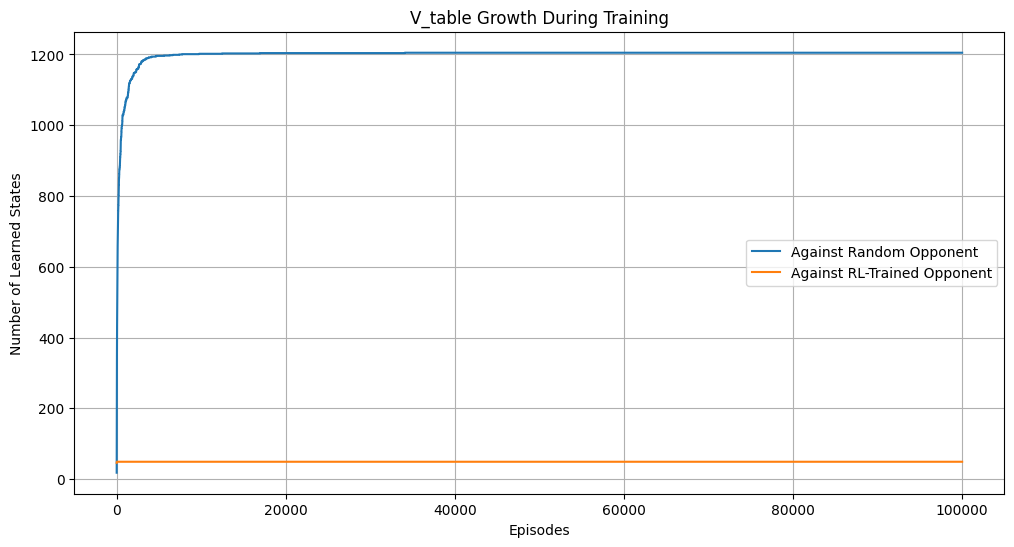

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(v_table_lengths_random_opponent, label='Against Random Opponent')
plt.plot(v_table_lengths_rl_opponent, label='Against RL-Trained Opponent')
plt.title('V_table Growth During Training')
plt.xlabel('Episodes')
plt.ylabel('Number of Learned States')
plt.legend()
plt.grid(True)
plt.show()


## Observations from V_table Growth Plot

From the plot of `V_table` growth during training, we can make the following observations:

1.  **Against a Random Opponent**: The `V_table` grows significantly and steadily over the 100,000 episodes. This indicates that the agent encounters a large number of unique states and learns their values when playing against a non-deterministic random opponent. The exploration of the state space is extensive, leading to a richer `V_table`.

2.  **Against an RL-Trained Opponent**: The `V_table` growth is much slower and plateaus very quickly at a small number of states. This suggests that when the agent plays against another agent that is also learning and making optimal (or near-optimal) moves, the game converges to a smaller set of explored states. Both agents quickly learn the most effective paths and avoid less optimal, more exploratory sequences, thus limiting the number of unique states encountered and valued.

3.  **Comparison**: There is a stark difference in the scale of `V_table` growth. Playing against a random opponent leads to learning hundreds (or thousands) of states, while playing against an RL opponent limits the learned states to a very small number (around 49 states in this case). This highlights how the opponent's strategy impacts the agent's exploration and the resulting state space it needs to learn.